# Zadanie domowe 2
Agata Kaczmarek

To zadanie składa się z dwóch części: kodowania zmiennych kategorycznych oraz uzupełniania braków. W pierwszej z nich porównam target encoding (dla *it_location*) oraz one-hot encoding. Następnie dla *main_category* zastosuję trzy różne metody encodingu - one-hot, count oraz binary. W drugiej części zadania przeanalizuję efekty uzupełnienia 10% danych z pomocą automatycznego narzędzia.

Wczytanie danych oraz bibliotek

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import random
warnings.filterwarnings('ignore')
np.random.seed = 42

from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder
from category_encoders import CountEncoder
from category_encoders import BinaryEncoder

from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error


In [89]:
allegro=pd.read_csv("https://www.dropbox.com/s/360xhh2d9lnaek3/allegro-api-transactions.csv?dl=1")
allegro.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,Warszawa,Komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,Warszawa,"Odzież, Obuwie, Dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,Leszno,Dom i Ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,Wola Krzysztoporska,Książki i Komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,BIAŁYSTOK,"Odzież, Obuwie, Dodatki"


In [90]:
allegro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420020 entries, 0 to 420019
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lp                      420020 non-null  int64  
 1   date                    420020 non-null  object 
 2   item_id                 420020 non-null  int64  
 3   categories              420020 non-null  object 
 4   pay_option_on_delivery  420020 non-null  int64  
 5   pay_option_transfer     420020 non-null  int64  
 6   seller                  420020 non-null  object 
 7   price                   420020 non-null  float64
 8   it_is_allegro_standard  420020 non-null  int64  
 9   it_quantity             420020 non-null  int64  
 10  it_is_brand_zone        420020 non-null  int64  
 11  it_seller_rating        420020 non-null  int64  
 12  it_location             420020 non-null  object 
 13  main_category           420020 non-null  object 
dtypes: float64(1), int64

Nazwy w kolumnach *it_location* oraz *main_category* są pisane literami różnych wielkości, więc zmieńmy je wszystkie na małe na początku.

In [91]:
allegro['it_location']=allegro['it_location'].str.lower()
allegro['main_category']=allegro['main_category'].str.lower()
allegro.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,warszawa,komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,warszawa,"odzież, obuwie, dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,leszno,dom i ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,wola krzysztoporska,książki i komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,białystok,"odzież, obuwie, dodatki"


Zanim zacznę zmieniać dane, to stworzę kopię dla każdego planowanego kodowania, by się nie psuły nawzajem.

In [92]:
allegro_target=allegro.copy()
allegro_one_encoding=allegro.copy()
allegro_count=allegro.copy()
allegro_binary=allegro.copy()

### 1.Kodowanie zmiennych

Przyjrzyjmy się na początku kolumnie *it_location* bardziej szczegółowo. Jak widzimy poniżej zawiera ona 7903 różne wartości. W takim wypadku zastosowanie one-hot spowodowałoby dodanie nowych 7903 kolumn, co jest znaczną ilością, w szczególności że nasze początkowe dane mają tylko 14 kolumn. Zastosujmy w takim razie target encoding.

In [93]:
allegro_target['it_location'].describe()

count       420020
unique        7903
top       warszawa
freq         27042
Name: it_location, dtype: object

Target encoding grupuje dane według kategorii a następnie przypisuje kategoriom średnią wartość. Taka wartość przypisywana jest wszystkim obserwacjom należącym do danej kategorii.

In [94]:
encoder=TargetEncoder()
allegro_target['it_location_encoded']=encoder.fit_transform(allegro_target['it_location'], allegro_target['price'])
allegro_target

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category,it_location_encoded
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,warszawa,komputery,84.132898
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,warszawa,"odzież, obuwie, dodatki",84.132898
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,leszno,dom i ogród,64.883187
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,wola krzysztoporska,książki i komiksy,35.433365
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,białystok,"odzież, obuwie, dodatki",73.772916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420015,420015,2016-04-03 20:27:13,6099625607,"['RTV i AGD', 'Sprzęt audio dla domu', 'Odtwar...",0,0,iwona7012,180.00,0,0,0,176,kraśnik,rtv i agd,26.346402
420016,420016,2016-04-03 22:35:02,6099634607,"['Uroda', 'Makijaż', 'Oczy', 'Tusze do rzęs']",1,1,Dolce_Cosmetics,14.99,1,2,0,34851,dzierżoniów,uroda,63.645927
420017,420017,2016-04-03 22:38:57,6099780407,"['Odzież, Obuwie, Dodatki', 'Przebrania, kosti...",1,1,pewex4all,5.99,1,470,0,983,supraśl,"odzież, obuwie, dodatki",18.682800
420018,420018,2016-04-03 22:44:17,6099801007,"['Dla Dzieci', 'Rowery i pojazdy', 'Rowery bie...",1,0,kostasia,200.00,0,0,0,163,poznań,dla dzieci,104.254805


Jak widać target encoding wymaga tylko jednej dodatkowej kolumny, więc dużo mniej niż one-hot. Jednak ten sposób jest bardziej podatny na przeuczenia, co więcej np w tym przypadku wcześniej nieporównywalne dane (nazwy miast) zamienione zostały na wartości numeryczne, które już łatwo porównywać, co może prowadzić do błędów.

#### Inne metody encodingu

W tej części zadania będziemy używać kolumny *main_category*. Sprawdźmy czy jest ona może bardziej "przyjazna" dla one-hot. Jak widać ponieżej, tak jest, ma ona tylko 27 różnych wartości, czyli przybędzie nam tylko 27 nowych kolumn po zastosowaniu one-hot.

In [95]:
allegro_target['main_category'].describe()

count          420020
unique             27
top       dom i ogród
freq            91042
Name: main_category, dtype: object

##### One-hot

In [96]:
one_hot_enc=OneHotEncoder(use_cat_names=True).fit_transform(allegro_one_encoding['main_category'])
one_hot_enc.head()




,main_category_komputery,"main_category_odzież, obuwie, dodatki",main_category_dom i ogród,main_category_książki i komiksy,main_category_biżuteria i zegarki,main_category_rtv i agd,main_category_motoryzacja,main_category_dla dzieci,main_category_uroda,main_category_telefony i akcesoria,...,main_category_filmy,main_category_fotografia,main_category_biuro i reklama,main_category_instrumenty,main_category_muzyka,main_category_konsole i automaty,"main_category_sprzęt estradowy, studyjny i dj-ski",main_category_antyki i sztuka,main_category_bilety,main_category_nieruchomości
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Jak widzimy powstało 27 nowych kolumn, w których występują wartości 0 lub 1. Ten encoding dobrze oddziela od siebie różne kategorie.

##### Count Encoder

In [97]:
count_enc=CountEncoder().fit_transform(allegro_count['main_category'])
count_enc.head()

,main_category
0,14491
1,54257
2,91042
3,11572
4,54257


Ten encoder zlicza ilość wystąpień elementu w kolumnie i w miejscu dla danej obserwacji wpisuje odpowiednią dla kategorii ilość.

##### Binary

In [98]:
binary_enc=BinaryEncoder().fit_transform(allegro_binary['main_category'])
binary_enc.head()

,main_category_0,main_category_1,main_category_2,main_category_3,main_category_4,main_category_5
0,0,0,0,0,0,1
1,0,0,0,0,1,0
2,0,0,0,0,1,1
3,0,0,0,1,0,0
4,0,0,0,0,1,0


Binary encoding również jest odpowiednie dla zmiennych kategorycznych, jest bardzo podobny do OneHot encoding, różnica jest to, że przechowuje categorie jako binarne bitstringi.

### 2. Uzupełnianie braków

In [99]:
allegro.head()

,lp,date,item_id,categories,pay_option_on_delivery,pay_option_transfer,seller,price,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,0,2016-04-03 21:21:08,4753602474,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,59.99,1,997,0,50177,warszawa,komputery
1,1,2016-04-03 15:35:26,4773181874,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,4.90,1,9288,0,12428,warszawa,"odzież, obuwie, dodatki"
2,2,2016-04-03 14:14:31,4781627074,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,109.90,1,895,0,7389,leszno,dom i ogród
3,3,2016-04-03 19:55:44,4783971474,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,18.50,0,971,0,15006,wola krzysztoporska,książki i komiksy
4,4,2016-04-03 18:05:54,4787908274,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,19.90,1,950,0,32975,białystok,"odzież, obuwie, dodatki"


Ograniczam zbiór danych, w szczególności jego rozmiar.

In [100]:
allegro_cut=allegro[['price', 'it_seller_rating', 'it_quantity']].copy()
allegro_cut=allegro_cut[1:2000]
allegro_cut_1=allegro_cut.copy()
allegro_cut.head()

,price,it_seller_rating,it_quantity
1,4.90,12428,9288
2,109.90,7389,895
3,18.50,15006,971
4,19.90,32975,950
5,10.99,39371,742


Usuńmy 10% obserwacji ze zmiennej it_seller_rating i uzupełnijmy je z użyciem narzędzia Nearest neighbors imputation.

In [101]:
allegro_cut.loc[allegro_cut.sample(frac=0.1).index, 'it_seller_rating'] = np.nan
allegro_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 1 to 1999
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             1999 non-null   float64
 1   it_seller_rating  1799 non-null   float64
 2   it_quantity       1999 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 46.9 KB


In [102]:
allegro_cut.head(10)

,price,it_seller_rating,it_quantity
1,4.90,12428.0,9288
2,109.90,7389.0,895
3,18.50,15006.0,971
4,19.90,32975.0,950
5,10.99,39371.0,742
6,10.99,39371.0,742
7,28.99,NaN,886
8,12.00,5403.0,49
9,45.00,15561.0,4
10,1.50,5430.0,0


In [103]:
imputer=KNNImputer()
allegro_imputed=pd.DataFrame(imputer.fit_transform(allegro_cut), columns=allegro_cut.columns)
allegro_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             1999 non-null   float64
 1   it_seller_rating  1999 non-null   float64
 2   it_quantity       1999 non-null   float64
dtypes: float64(3)
memory usage: 46.9 KB


In [104]:
allegro_imputed['it_seller_rating']

0       12428.0
1        7389.0
2       15006.0
3       32975.0
4       39371.0
         ...   
1994     2977.0
1995      260.0
1996      602.0
1997      761.0
1998     1050.0
Name: it_seller_rating, Length: 1999, dtype: float64

In [105]:
error=np.sqrt(mean_squared_error(allegro_imputed["it_seller_rating"], allegro_cut_1["it_seller_rating"]))

Analogiczny eksperyment powtórzony 10 razy.

In [108]:
rmse_error=[]
for i in range (10):
    allegro_cut.loc[allegro_cut_1.sample(frac=0.1).index, 'it_seller_rating'] = np.nan
    imputer=KNNImputer(n_neighbors=4)
    allegro_imputed=pd.DataFrame(imputer.fit_transform(allegro_cut), columns=allegro_cut.columns)
    error=np.sqrt(mean_squared_error(allegro_imputed["it_seller_rating"], allegro_cut_1["it_seller_rating"]))
    rmse_error.append(error)
    print(error)

29994.39595584174
29868.689418438877
30967.092502083222
31844.13294961197
32222.307746994004
33630.67834101953
33789.9853195932
34138.71604522884
34656.03005916656
35369.382736903004


In [109]:
np.std(rmse_error)

1853.3531211608679

Teraz zrobię analogiczną analizę usuwając losowo 10% kolumny *it_seller_rating* oraz 10% kolumny *it_quantity*.

In [111]:
rmse_seller_error=[]
rmse_quantity_error=[]
for i in range (10):
    allegro_cut.loc[allegro_cut_1.sample(frac=0.1).index, 'it_seller_rating'] = np.nan
    allegro_cut.loc[allegro_cut.sample(frac=0.1).index, 'it_quantity'] = np.nan
    imputer=KNNImputer(n_neighbors=4)
    allegro_imputed=pd.DataFrame(imputer.fit_transform(allegro_cut), columns=allegro_cut.columns)
    error1=np.sqrt(mean_squared_error(allegro_imputed["it_seller_rating"], allegro_cut_1["it_seller_rating"]))
    error2=np.sqrt(mean_squared_error(allegro_imputed["it_quantity"], allegro_cut_1["it_quantity"]))
    rmse_seller_error.append(error1)
    rmse_quantity_error.append(error2)
    print("RMSE it_seller_ranking ", error1)
    print("RMSE it_quantity ", error2)

RMSE it_seller_ranking  34072.669837839356
RMSE it_quantity  6472.698835057497
RMSE it_seller_ranking  34324.44910671805
RMSE it_quantity  10293.18810272583
RMSE it_seller_ranking  35980.664151889
RMSE it_quantity  11396.847577027747
RMSE it_seller_ranking  35651.85705186949
RMSE it_quantity  13504.022175078617
RMSE it_seller_ranking  36415.88444697841
RMSE it_quantity  15141.610958655427
RMSE it_seller_ranking  35778.31136772546
RMSE it_quantity  16417.57840044147
RMSE it_seller_ranking  36283.304076654225
RMSE it_quantity  17427.350249477193
RMSE it_seller_ranking  36301.119827700786
RMSE it_quantity  18308.417395540422
RMSE it_seller_ranking  37471.50724296685
RMSE it_quantity  19189.97655597472
RMSE it_seller_ranking  37325.999505415646
RMSE it_quantity  20001.781757166646


In [113]:
print(np.std(rmse_seller_error))
print(np.std(rmse_quantity_error))

1046.1718821040038
4137.506437875874


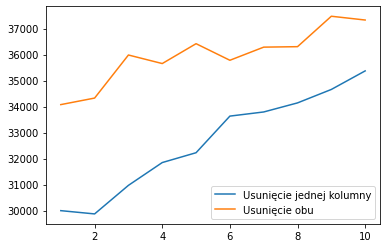

In [116]:
plt.plot(range(1,11), rmse_error, range(1,11), rmse_seller_error)
plt.legend(['Usunięcie jednej kolumny', 'Usunięcie obu'])

#### Wnioski

Jak widać z powyżeszego wykresu, błęd zwiększa się, co więcej jest znacznie większy gdy imputujemy dane z dwóch kolumn, a nie tylko z jednej.